In [23]:
import random
import warnings

import lightgbm as lgbm
import numpy as np
import pandas as pd
from lightgbm import early_stopping
from lightgbm import log_evaluation
from lightgbm import record_evaluation
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

warnings.filterwarnings("ignore")

In [24]:
X = pd.read_csv('C:/Users/Lenovo/Downloads/processed_dataset_ul.csv')
X


print(f"X shape: {X.shape}")

X.head()

X shape: (2919, 226)


,id,house_lot_frontage,house_lot_area,house_lot_shape,house_land_contour,house_land_slope,house_overall_quality,house_overall_condition,house_year_built,house_remodeling_year,...,exterior_Other,geo_condition_Norm,geo_condition_Feedr,geo_condition_PosN,geo_condition_Artery,geo_condition_RRAe,geo_condition_RRNn,geo_condition_RRAn,geo_condition_PosA,geo_condition_RRNe
0,1,65.0,8450,0,0,0,7,5,2003,2003,...,0,1,0,0,0,0,0,0,0,0
1,2,80.0,9600,0,0,0,6,8,1976,1976,...,0,1,1,0,0,0,0,0,0,0
2,3,68.0,11250,1,0,0,7,5,2001,2002,...,0,1,0,0,0,0,0,0,0,0
3,4,60.0,9550,1,0,0,7,5,1915,1970,...,0,1,0,0,0,0,0,0,0,0
4,5,84.0,14260,1,0,0,8,5,2000,2000,...,0,1,0,0,0,0,0,0,0,0


# 3. Distance to cluster center as a feature

In [26]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

numeric_features = X.select_dtypes(include=['int64', 'float64'])

# # Масштабирование признаков
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Выбор числа кластеров (может потребоваться настроить)
n_clusters = 5

# Создание и обучение модели SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = spectral_clustering.fit_predict(X_scaled)

# Вычисление центров кластеров
cluster_centers = []
for cluster_label in range(n_clusters):
    cluster_points = X_scaled[clusters == cluster_label]
    cluster_center = cluster_points.mean(axis=0)
    cluster_centers.append(cluster_center)

# Вычисление расстояний от каждой точки до центра своего кластера
distances_to_cluster_center = pairwise_distances(X_scaled, cluster_centers)

# Добавление нового признака в исходный набор данных
X['distance_to_cluster_center'] = distances_to_cluster_center.min(axis=1)

# Отображение результатов
print(X['distance_to_cluster_center'])


0        7.586654
1       15.279809
2        7.380920
3       13.846876
4       12.043204
          ...    
2914    15.503677
2915    20.477737
2916    11.174010
2917    16.856496
2918    10.309504
Name: distance_to_cluster_center, Length: 2919, dtype: float64


# 2. Anomaly Detection:Isolation Forest


In [19]:
# Filter only numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64'])



# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
numeric_features_imputed = imputer.fit_transform(numeric_features)

# Create and train Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(numeric_features_imputed)

# Predict anomalies
anomaly_labels = isolation_forest.predict(numeric_features_imputed)

# Display results
print("Anomaly labels:", anomaly_labels)


Anomaly labels: [1 1 1 ... 1 1 1]


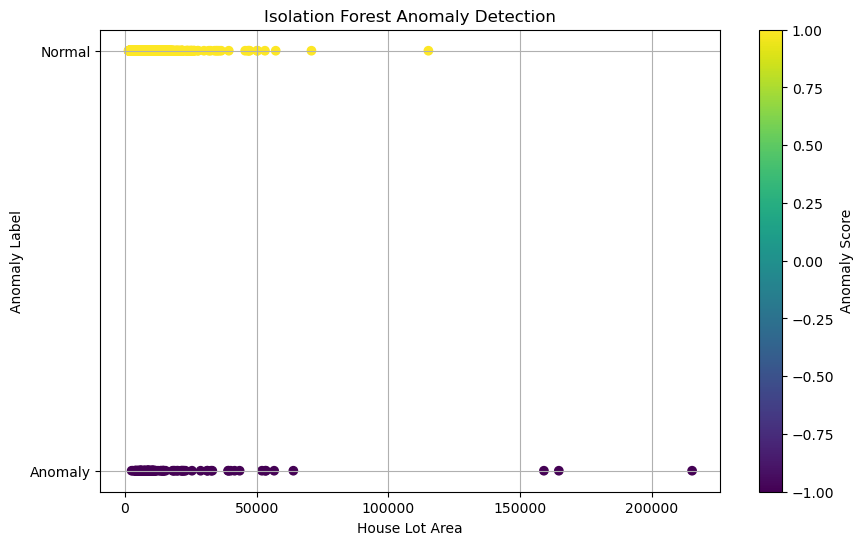

In [22]:
import matplotlib.pyplot as plt

# Фильтрация данных для графика (используем только house_lot_area)
data_to_plot = numeric_features[['house_lot_area']].copy()
data_to_plot['anomaly_labels'] = anomaly_labels

# График
plt.figure(figsize=(10, 6))
plt.scatter(data_to_plot['house_lot_area'], data_to_plot['anomaly_labels'], c=data_to_plot['anomaly_labels'], cmap='viridis')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('House Lot Area')
plt.ylabel('Anomaly Label')
plt.yticks([-1, 1], ['Anomaly', 'Normal'])
plt.colorbar(label='Anomaly Score')
plt.grid(True)
plt.show()
